In [2]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce GTX 1070


## Load and prepare train and test sets

In [ ]:
DATASET_PATH = "fashion_dataset/"

In [3]:
# Train set

train_df = pd.read_csv(DATASET_PATH + "train.csv", error_bad_lines=False).drop(['Unnamed: 0'], axis=1)
train_df['image'] = train_df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
train_df.head(5)

/home/ewaisha/anaconda3/envs/cnn_finetune/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,3559,Men,Footwear,Shoes,Casual Shoes,Brown,Winter,2015.0,Casual,Skechers Men's Casual Brown Lifestyle Shoe,3559.jpg
1,15232,Men,Footwear,Shoes,Casual Shoes,Brown,Fall,2011.0,Casual,ADIDAS Originals Men Vespa PK LO Brown Casual ...,15232.jpg
2,32186,Men,Footwear,Shoes,Sports Shoes,White,Summer,2012.0,Sports,ADIDAS Men Sprint Speed White Sports Shoes,32186.jpg
3,55618,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Numero Uno Men Black Shoes,55618.jpg
4,6830,Men,Footwear,Shoes,Sports Shoes,Black,Summer,2011.0,Sports,Nike Men's Zoom Vomero Black Shoe,6830.jpg


In [6]:
# Test set

test_df = pd.read_csv(DATASET_PATH + "test.csv", error_bad_lines=False).drop(['Unnamed: 0'], axis=1)
test_df['image'] = test_df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
test_df.head(5)

/home/ewaisha/anaconda3/envs/cnn_finetune/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,4412,Men,Apparel,Topwear,Tshirts,Black,Summer,2017.0,Casual,Pink Floyd Black Original Dark Side Black T-shirt,4412.jpg
1,23306,Women,Apparel,Topwear,Kurtas,Blue,Fall,2011.0,Ethnic,W Women Blue Kurta,23306.jpg
2,33908,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Citizen Men Black Dial Watch BI0950-51E,33908.jpg
3,7170,Men,Apparel,Topwear,Shirts,Red,Fall,2011.0,Casual,Scullers Men Scul White Red Shirt,7170.jpg
4,20153,Men,Apparel,Topwear,Shirts,Blue,Fall,2011.0,Casual,Wrangler Men Taylor Block Check Blue Shirt,20153.jpg


### Limit dataset size (for faster training just for a proof of concept)

In [4]:
print(len(train_df))
train_df = train_df.sample(n=5000)
print(len(train_df))

34727
5000


In [7]:
print(len(test_df))
test_df = test_df.sample(n=1000)
print(len(test_df))

8682
1000


In [8]:
num_classes = len(train_df['subCategory'].unique())
print(num_classes)

22


In [9]:
# Dictionaries to map text labels to numbers

cls_map = {x:i for i, x in enumerate(train_df['subCategory'].unique())}
inv_cls_map = {x:i for i, x in cls_map.items()}

In [10]:
class CustomImageDataset(Dataset):
    """
    This class implememts a custom dataloader for our dataset.
    
    root_dir: the root directory for the dataset
    df: the dataframe to read (either train df or test df)
    transform: the image transformations to be done to the returned image
    """
    
    def __init__(self, root_dir, df, transform=None):
        self.root_dir = root_dir
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_id = str(self.df.iloc[index, 0])
        img = Image.open(os.path.join(self.root_dir, "images", img_id+".jpg")).convert("RGB")
        # get the sub-category label and map it to a number
        category = torch.tensor(cls_map[self.df.iloc[index, 3]])

        if self.transform is not None:
            img = self.transform(img)

        return {'image': img, 'label': category}

In [48]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 5)
        self.conv5 = nn.Conv2d(256, 512, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(4608, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.out(x)
        
        return x

### MACCs
#### Formula for conv layers: (K^2) * C_in * H_out * W_out * C_out
- conv1 Mac --> 0.116 GMACCs
- conv2 Mac --> 0.619 GMACCs
- conv3 Mac --> 0.575 GMACCs
- conv4 Mac --> 0.47 GMACCs
- conv5 Mac --> 0.32 GMACCs
- fc1 Mac --> 4608*512 = 2359296 MACCs
- fc2 Mac --> 512*256 = 131072 MACCs
- fc3 Mac --> 256*22 = 5632 MACCs

#### FLOPS = MACCs * 2 approx (as 1 multiply is one FLOP and one addition is another)

#### Convolutional layers are more computationally expensive.

#### MACCs/FLOPS can be decreased for convolutional layers if we replace the normal convolution with a depth-wise followed by point-wise convolution. This way the kernel does not "scan" the entire input volume, just a single channel, then we perform 1x1 conv on the resulting volume to obtain the desired depth/number of channels.

In [ ]:
# training function

def train(model, device, train_loader, optimizer, epoch, writer):
    model.train()
    train_loss = 0
    correct = 0

    print("Epoch", epoch)
    for i_batch, item in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = item['image'].to(device)
        labels = item['label'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = F.nll_loss(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss += F.nll_loss(outputs, labels, reduction='sum').item()
        pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('Train Loss: {:.6f} \tTrain Accuracy: {}'.format(train_loss, 100. * correct / len(train_loader.dataset)))

    writer.add_scalar('Loss/train', train_loss, epoch)

In [ ]:
# Evaluation function

current_loss = 5
def test(model, device, test_loader, epoch, writer, exp_name):
    model.eval()
    global current_loss
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for item in test_loader:
            images = item['image'].to(device)
            labels = item['label'].to(device)
            outputs = model(images)
            test_loss += F.nll_loss(outputs, labels, reduction='sum').item()  # sum up batch loss
            pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('Test Loss: {:.4f} \tTest Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    if test_loss <= current_loss:
        current_loss = test_loss
        print("Saving model with lowest loss..\n")
        torch.save(model.state_dict(), "./weights/{}_{}_{}.pt".format(exp_name, epoch, int(test_loss*100)))

    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/test', correct/len(test_loader.dataset), epoch)

In [53]:
# Training settings

batch_size = 8
epochs = 50
lr = 0.0001
gamma = 0.1
no_cuda = False
seed = 1
save_interval = 10
save_model = True
exp_name = "custom"

use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 8, 'pin_memory': True} if use_cuda else {}
print("Using: {}".format(device))

Using: cuda


In [13]:
# Image transforms
transforms_train = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
transforms_test = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

# Dataloaders
train_data_set = CustomImageDataset("./fashion_dataset", train_df, transforms_train)
train_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, **kwargs)

test_data_set = CustomImageDataset("./fashion_dataset", test_df, transforms_test)
test_loader = DataLoader(test_data_set, batch_size=batch_size, shuffle=True, **kwargs)


# Model
model = Net(num_classes).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=gamma)
writer = SummaryWriter(filename_suffix = exp_name)
summary(model, input_size=(3, 224, 224))

Using: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 220, 220]           2,432
         MaxPool2d-2         [-1, 32, 110, 110]               0
            Conv2d-3         [-1, 64, 106, 106]          51,264
         MaxPool2d-4           [-1, 64, 53, 53]               0
            Conv2d-5          [-1, 128, 49, 49]         204,928
         MaxPool2d-6          [-1, 128, 24, 24]               0
            Conv2d-7          [-1, 256, 20, 20]         819,456
         MaxPool2d-8          [-1, 256, 10, 10]               0
            Conv2d-9            [-1, 512, 6, 6]       3,277,312
        MaxPool2d-10            [-1, 512, 3, 3]               0
           Linear-11                  [-1, 512]       2,359,808
           Linear-12                  [-1, 256]         131,328
           Linear-13                   [-1, 22]           5,654
       LogSoftmax-14       

In [14]:
# Training Loop
for epoch in range(1, epochs+1):
    try:
        train(model, device, train_loader, optimizer, epoch, writer)
        test(model, device, test_loader, epoch, writer, exp_name)
        scheduler.step()

        if epoch%save_interval == 0:
            print("Saving Model...\n")
            torch.save(model.state_dict(), "./weights/{}_{}.pt".format(exp_name, epoch))

    except KeyboardInterrupt:
        print("Stopping early. Saving network...\n")
        torch.save(model.state_dict(), "./weights/{}_{}.pt".format(exp_name, epoch))
        break

Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [03:01<00:00,  3.43it/s]


Train Loss: 1.606937 	Train Accuracy: 55.04
Test Loss: 1.0186 	Test Accuracy: 680/1000 (68%)

Saving model with lowest loss..

Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:42<00:00,  3.84it/s]


Train Loss: 0.754621 	Train Accuracy: 77.18
Test Loss: 0.6956 	Test Accuracy: 778/1000 (78%)

Saving model with lowest loss..

Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:37<00:00,  3.97it/s]


Train Loss: 0.508500 	Train Accuracy: 84.54
Test Loss: 0.5277 	Test Accuracy: 855/1000 (86%)

Saving model with lowest loss..

Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:32<00:00,  4.09it/s]

Train Loss: 0.403712 	Train Accuracy: 87.52


Test Loss: 0.4804 	Test Accuracy: 860/1000 (86%)

Saving model with lowest loss..

Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:30<00:00,  4.16it/s]


Train Loss: 0.323446 	Train Accuracy: 89.6
Test Loss: 0.4357 	Test Accuracy: 868/1000 (87%)

Saving model with lowest loss..

Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:25<00:00,  4.29it/s]

Train Loss: 0.270389 	Train Accuracy: 90.96


Test Loss: 0.4206 	Test Accuracy: 867/1000 (87%)

Saving model with lowest loss..

Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:34<00:00,  4.03it/s]


Train Loss: 0.221432 	Train Accuracy: 93.04
Test Loss: 0.4191 	Test Accuracy: 871/1000 (87%)

Saving model with lowest loss..

Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:30<00:00,  4.16it/s]

Train Loss: 0.193605 	Train Accuracy: 93.56


Test Loss: 0.3923 	Test Accuracy: 886/1000 (89%)

Saving model with lowest loss..

Epoch 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:35<00:00,  4.03it/s]

Train Loss: 0.159523 	Train Accuracy: 94.56


Test Loss: 0.3873 	Test Accuracy: 885/1000 (88%)

Saving model with lowest loss..

Epoch 10


 14%|█████████████████                                                                                                            | 85/625 [00:16<01:46,  5.09it/s]


Stopping early. Saving network...



## Visualize some Results

In [116]:
# Load latest model
model = Net(num_classes).cuda()
state_dict = torch.load("./weights/custom_10.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [117]:
test(model, device, test_loader, epoch, writer, exp_name)

Test Loss: 0.4224 	Test Accuracy: 890/1000 (89%)



Ground Truth: Bags
Prediction: Bags


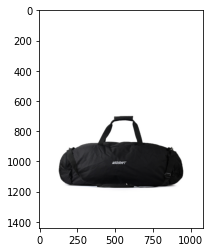

Ground Truth: Topwear
Prediction: Topwear


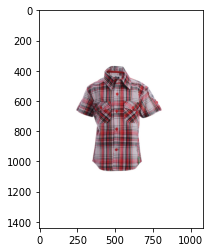

Ground Truth: Topwear
Prediction: Topwear


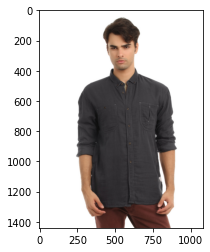

Ground Truth: Belts
Prediction: Belts


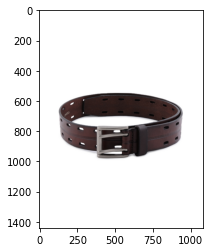

Ground Truth: Watches
Prediction: Watches


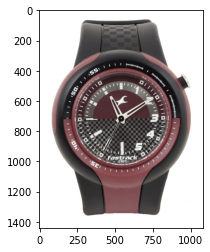

Ground Truth: Shoes
Prediction: Shoes


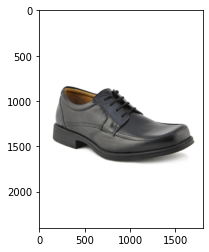

Ground Truth: Topwear
Prediction: Topwear


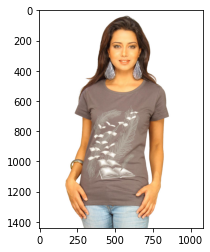

Ground Truth: Jewellery
Prediction: Jewellery


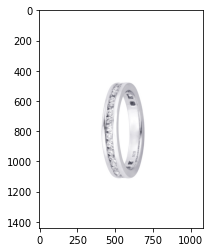

Ground Truth: Watches
Prediction: Watches


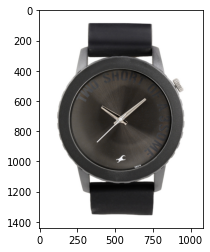

Ground Truth: Topwear
Prediction: Topwear


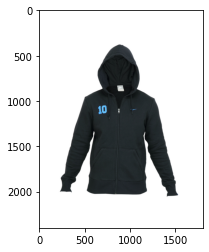

Ground Truth: Shoes
Prediction: Shoes


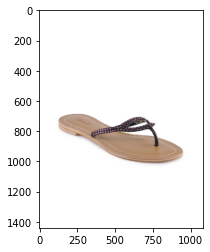

Ground Truth: Bottomwear
Prediction: Bottomwear


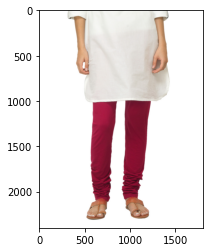

Ground Truth: Topwear
Prediction: Topwear


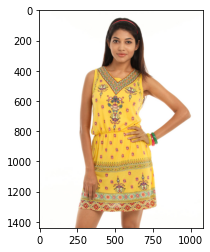

Ground Truth: Shoes
Prediction: Shoes


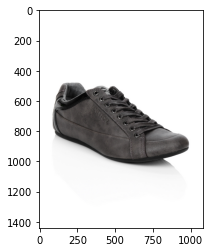

Ground Truth: Watches
Prediction: Watches


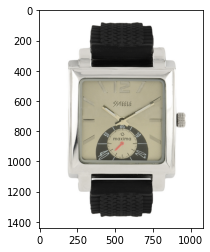

Ground Truth: Flip Flops
Prediction: Flip Flops


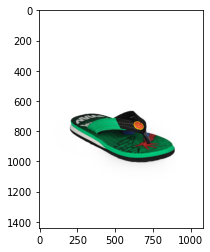

Ground Truth: Eyewear
Prediction: Eyewear


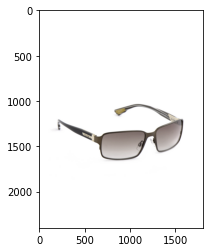

Ground Truth: Loungewear and Nightwear
Prediction: Topwear


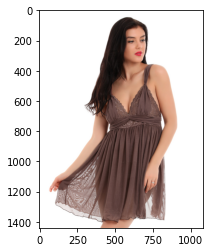

Ground Truth: Jewellery
Prediction: Jewellery


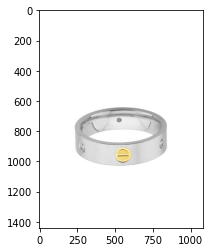

Ground Truth: Topwear
Prediction: Topwear


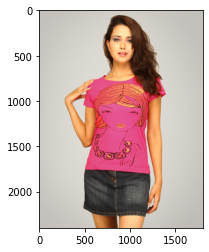

Ground Truth: Loungewear and Nightwear
Prediction: Bottomwear


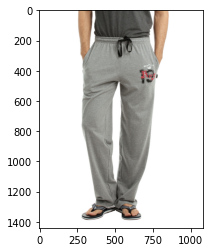

In [52]:
for i, (ind, row) in enumerate(test_df.iterrows()):
    if i > 20:
        break
    img_name = row['image']
    img = Image.open(os.path.join("./fashion_dataset/images", img_name)).convert("RGB")
    img_tensor = transforms_test(img).unsqueeze(0)
    label = row['subCategory']
    outputs = model(img_tensor.to(device))
    pred = outputs.argmax(dim=1, keepdim=True)
    pred = inv_cls_map[int(pred)]
    
    print("Ground Truth:", label)
    print("Prediction:", pred)
    plt.imshow(img)
    plt.show()

## Receptive field analysis

### Computing the networks receptive field for each layer
#### Overall receptive field is 156x156

In [58]:
from torch_receptive_field import receptive_field

class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 5)
        self.conv5 = nn.Conv2d(256, 512, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(4608, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        return x
    
    
receptive_field(Net(num_classes).cuda(), input_size=(3, 224, 224));

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1             [220, 220]        2.5        1.0             5.0 
        2             [110, 110]        3.0        2.0             6.0 
        3             [106, 106]        7.0        2.0            14.0 
        4               [53, 53]        8.0        4.0            16.0 
        5               [49, 49]       16.0        4.0            32.0 
        6               [24, 24]       18.0        8.0            36.0 
        7               [20, 20]       34.0        8.0            68.0 
        8               [10, 10]       38.0       16.0            76.0 
        9                 [6, 6]       70.0       16.0           140.0 
        10                [3, 3]       78.0       32.0           156.0 


### Example of increasing/decreasing the receptive field

#### Increasing the receptive field can be done by adding more convolutional or pooling layers. In this example, we added an extra layer with a 2x2 kernel (a larger kernel would violate the resulting spatial feature dimensions)

In [60]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 5)
        self.conv5 = nn.Conv2d(256, 512, 5)
        self.conv6 = nn.Conv2d(512, 512, 2)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(4608, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        return x
    

receptive_field(Net(num_classes).cuda(), input_size=(3, 224, 224));

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1             [220, 220]        2.5        1.0             5.0 
        2             [110, 110]        3.0        2.0             6.0 
        3             [106, 106]        7.0        2.0            14.0 
        4               [53, 53]        8.0        4.0            16.0 
        5               [49, 49]       16.0        4.0            32.0 
        6               [24, 24]       18.0        8.0            36.0 
        7               [20, 20]       34.0        8.0            68.0 
        8               [10, 10]       38.0       16.0            76.0 
        9                 [6, 6]       70.0       16.0           140.0 
        10                [3, 3]       78.0       32.0           156.0 
        11                [2, 2]       94.0       32.0   

#### Decreasing the receptive field can be done in the same manner by removing conv or pool layers

In [61]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(4608, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        return x
    

receptive_field(, input_size=(3, 224, 224));

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1             [220, 220]        2.5        1.0             5.0 
        2             [110, 110]        3.0        2.0             6.0 
        3             [106, 106]        7.0        2.0            14.0 
        4               [53, 53]        8.0        4.0            16.0 
        5               [49, 49]       16.0        4.0            32.0 
        6               [24, 24]       18.0        8.0            36.0 
        7               [20, 20]       34.0        8.0            68.0 
        8               [10, 10]       38.0       16.0            76.0 
